# 1. Imports

## 1.1. Libraries

In [2]:
import inflection
import datetime
import math

import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection as ms
from sklearn import preprocessing   as pp
from sklearn import metrics         as m
from scikitplot import metrics as mt

from IPython.core.display      import display, HTML
from IPython.display           import Image

from boruta import BorutaPy

from scipy import stats as ss

from keras import models as ml
from keras import layers as l

## 1.2. Helper Functions

In [3]:
def jupyter_settings():
    
    !matplotlib inline
    !pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 12
    
    display(HTML("<style>.container { width:95% !important; }</style>"))
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

In [4]:
jupyter_settings()

'matplotlib' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.
'pylab' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


## 1.3. Data

In [5]:
# train_users_2

df_raw = pd.read_csv('data/train_users_2.csv')

In [6]:
df_raw.shape

(213451, 16)

In [7]:
# sessions

df_sessions = pd.read_csv('data/sessions.csv')

In [8]:
df_sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [9]:
# granulariadade, cada usuario realiza varias ações, como registrado no csv 'sessions'

df_sessions.sort_values('user_id').head()

# cada ação pode ser convertida a uma nova variável, com indicação de ocorrência ou não por parte do usuário

,user_id,action,action_type,action_detail,device_type,secs_elapsed
3573962,00023iyk9l,personalize,data,wishlist_content_update,Mac Desktop,1767.0
3573933,00023iyk9l,requested,view,p5,Mac Desktop,702.0
3573934,00023iyk9l,requested,view,p5,Mac Desktop,3827.0
3573935,00023iyk9l,travel_plans_current,view,your_trips,Mac Desktop,474.0
3573949,00023iyk9l,personalize,data,wishlist_content_update,Mac Desktop,922.0


In [10]:
df_sessions[df_sessions['user_id'] == '00023iyk9l'][['user_id', 'action']].groupby('user_id').count()

,action
user_id,
00023iyk9l,39


In [11]:
df_sessions[df_sessions['user_id'] == '00023iyk9l'][['user_id', 'action']].value_counts()

user_id     action               
00023iyk9l  show                     9
            requested                5
            personalize              4
            index                    4
            dashboard                4
            similar_listings         3
            travel_plans_current     2
            header_userpic           2
            ajax_refresh_subtotal    2
            search_results           1
            pending                  1
            confirm_email            1
            callback                 1
dtype: int64

In [12]:
pd.DataFrame(df_sessions[df_sessions['user_id'] == '00023iyk9l'][['user_id', 'action']].value_counts()).T

user_id 00023iyk9l                                                                                                                                                               
action        show requested personalize index dashboard similar_listings travel_plans_current header_userpic ajax_refresh_subtotal search_results pending confirm_email callback
0                9         5           4     4         4                3                    2              2                     2              1       1             1        1

# 2. Data Description

In [13]:
df1 = df_raw.copy()

In [14]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 213451
Number of Columns: 16


In [15]:
df1.sample().T

,29389
id,f8rxsdyn8c
date_account_created,2012-06-27
timestamp_first_active,20120627035639
date_first_booking,NaN
gender,MALE
age,37
signup_method,facebook
signup_flow,0
language,en
affiliate_channel,direct


In [16]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [17]:
# date_account_created        
# timestamp_first_active       
# date_first_booking          
# age                        

In [18]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [19]:
df1 = df1.dropna()
df1.shape

(68171, 16)

In [20]:
# date_account_created    
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

# timestamp_first_active       
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format = '%Y%m%d%H%M%S')

# date_first_booking          
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

# age      
df1['age'] = df1['age'].astype(int)

In [21]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

In [22]:
df1['country_destination'].value_counts(normalize=True)

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

# 3. Filter

In [23]:
df2 = df1.copy()

## 3.1. Filtering rows

## 3.2. Filtering Columns

# 4. Data Preparation

In [24]:
df3 = df2.copy()

In [25]:
# dummie variables
df3_dummies = pd.get_dummies(df3.drop(['id', 'country_destination'], axis=1))

In [26]:
# join id and country
df3 = pd.concat([df3[['id', 'country_destination']], df3_dummies], axis=1)

In [27]:
df3.shape

(68171, 117)

In [28]:
df3

,id,country_destination,date_account_created,timestamp_first_active,date_first_booking,age,signup_flow,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,language_ca,language_cs,language_da,language_de,language_el,language_en,language_es,language_fi,language_fr,language_hu,language_is,language_it,language_ja,language_ko,language_nl,language_no,language_pl,language_pt,language_ru,language_sv,language_th,language_tr,language_zh,affiliate_channel_api,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,affiliate_provider_baidu,affiliate_provider_bing,affiliate_provider_craigslist,affiliate_provider_direct,affiliate_provider_email-marketing,affiliate_provider_facebook,affiliate_provider_facebook-open-graph,affiliate_provider_google,affiliate_provider_gsp,affiliate_provider_meetup,affiliate_provider_naver,affiliate_provider_other,affiliate_provider_padmapper,affiliate_provider_vast,affiliate_provider_yahoo,affiliate_provider_yandex,first_affiliate_tracked_linked,first_affiliate_tracked_local ops,first_affiliate_tracked_marketing,first_affiliate_tracked_omg,first_affiliate_tracked_product,first_affiliate_tracked_tracked-other,first_affiliate_tracked_untracked,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,first_device_type_Android Phone,first_device_type_Android Tablet,first_device_type_Desktop (Other),first_device_type_Mac Desktop,first_device_type_Other/Unknown,first_device_type_SmartPhone (Other),first_device_type_Windows Desktop,first_device_type_iPad,first_device_type_iPhone,first_browser_-unknown-,first_browser_AOL Explorer,first_browser_Android Browser,first_browser_Apple Mail,first_browser_Avant Browser,first_browser_BlackBerry Browser,first_browser_Camino,first_browser_Chrome,first_browser_Chrome Mobile,first_browser_Chromium,first_browser_CoolNovo,first_browser_Firefox,first_browser_IE,first_browser_IE Mobile,first_browser_IceWeasel,first_browser_Iron,first_browser_Kindle Browser,first_browser_Maxthon,first_browser_Mobile Firefox,first_browser_Mobile Safari,first_browser_Mozilla,first_browser_NetNewsWire,first_browser_Opera,first_browser_Opera Mini,first_browser_Pale Moon,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser
2,4ft3gnwmtx,US,2010-09-28,2009-06-09 23:12:47,2010-08-02,56,3,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,bjjt8pjhuk,other,2011-12-05,2009-10-31 06:01:29,2012-09-08,42,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,87mebub9p4,US,2010-09-14,2009-12-08 06:11:05,2010-02-18,41,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,lsw9q7uk0j,US,2010-01-02,2010-01-02 01:25:58,2010-01-05,46,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,0d01nltbrs,US,2010-01-03,2010-01-03 19:19:05,2010-01-13,47,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

# 5. Feature Selection

In [29]:
cols_drop = ['id', 'date_account_created','timestamp_first_active', 'date_first_booking'] # dates
df4 = df3.drop(cols_drop, axis=1)

In [30]:
X = df4.drop('country_destination', axis=1)
y = df4['country_destination'].copy()

# 6. ML Models

In [31]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

## 6.1. Baseline Model

***random*** — Generate pseudo-random numbers:

random.choices(population, weights=None, *, cum_weights=None, k=1)
***Return a k sized list of elements chosen from the population with replacement***. If the population is empty, raises IndexError.

***If a weights sequence is specified, selections are made according to the relative weights***. Alternatively, if a cum_weights sequence is given, the selections are made according to the cumulative weights (perhaps computed using itertools.accumulate()). For example, the relative weights [10, 5, 30, 5] are equivalent to the cumulative weights [10, 15, 45, 50]. Internally, the relative weights are converted to cumulative weights before making selections, so supplying the cumulative weights saves work.

***If neither weights nor cum_weights are specified, selections are made with equal probability***. If a weights sequence is supplied, it must be the same length as the population sequence. It is a TypeError to specify both weights and cum_weights.

The weights or cum_weights can use any numeric type that interoperates with the float values returned by random() (that includes integers, floats, and fractions but excludes decimals). Behavior is undefined if any weight is negative. A ValueError is raised if all weights are zero.

For a given seed, the choices() function with equal weighting typically produces a different sequence than repeated calls to choice(). The algorithm used by choices() uses floating point arithmetic for internal consistency and speed. The algorithm used by choice() defaults to integer arithmetic with repeated selections to avoid small biases from round-off error.

In [32]:
# population list
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
# list of weights in the same order as population
country_destination_weights = df1['country_destination'].value_counts(normalize=True).sort_index().tolist()
# size of the list generated
k_num = y_test.shape[0]

yhat_random = random.choices(population = country_destination_list,
                             weights=country_destination_weights,
                             k=k_num)

Accuracy: 0.5155848918225155
Balanced Accuracy: 0.0934689130692448
Kappa Score: 0.002900406165143421
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.01      0.01      0.01       214
          DE       0.02      0.02      0.02       170
          ES       0.03      0.03      0.03       345
          FR       0.06      0.06      0.06       710
          GB       0.04      0.04      0.04       344
          IT       0.04      0.04      0.04       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      0.70      0.70      9624
       other       0.12      0.12      0.12      1540

    accuracy                           0.52     13635
   macro avg       0.09      0.09      0.09     13635
weighted avg       0.52      0.52      0.52     13635



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

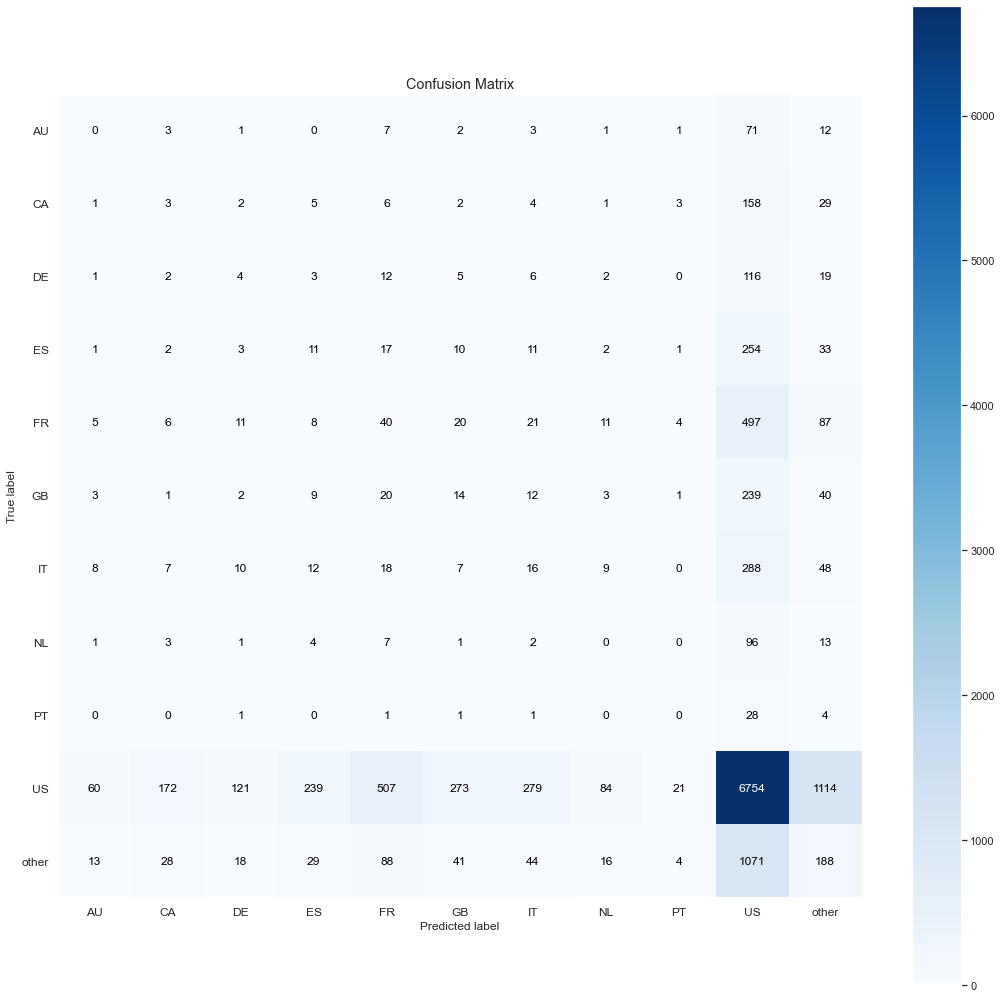

In [33]:
# BASELINE MODEL PERFORMANCE
# accuracy: In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))
# balanced accuracy: The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class.
balance_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balance_acc_random))
# kappa metrics: This function computes Cohen’s kappa [1], a score that expresses the level of agreement between two annotators on a classification problem. It is defined as
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))
# classification report: Build a text report showing the main classification metrics.
print(m.classification_report(y_test, yhat_random))
# confusion matrix: Compute confusion matrix to evaluate the accuracy of a classification.
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(18,18))

## 6.2. Neural Network

In [34]:
y_train.values.reshape(-1,1)

array([['US'],
       ['FR'],
       ['IT'],
       ...,
       ['US'],
       ['IT'],
       ['US']], dtype=object)

In [35]:
y_train.unique()

array(['US', 'FR', 'IT', 'other', 'GB', 'CA', 'ES', 'DE', 'NL', 'AU',
       'PT'], dtype=object)

In [38]:
ohe = pp.OneHotEncoder()

y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()
y_train_nn

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [39]:
# model definition
model = ml.Sequential()
model.add(l.Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(l.Dense(11, activation='softmax'))

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit(X_train, y_train_nn, epochs=100)

Epoch 1/100
1705/1705 [==============================] - 5s 3ms/step - loss: 1.3337 - accuracy: 0.7037
Epoch 2/100
1705/1705 [==============================] - 4s 3ms/step - loss: 1.2626 - accuracy: 0.7080
Epoch 3/100
1705/1705 [==============================] - 5s 3ms/step - loss: 1.2236 - accuracy: 0.7084
Epoch 4/100
1705/1705 [==============================] - 4s 3ms/step - loss: 1.2133 - accuracy: 0.7085
Epoch 5/100
1705/1705 [==============================] - 4s 3ms/step - loss: 1.1940 - accuracy: 0.7085
Epoch 6/100
1705/1705 [==============================] - 4s 3ms/step - loss: 1.1826 - accuracy: 0.7084
Epoch 7/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.1570 - accuracy: 0.7089
Epoch 8/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.1502 - accuracy: 0.7086
Epoch 9/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.1471 - accuracy: 0.7088
Epoch 10/100
1705/1705 [==============================] - 4s 2ms/step - l

In [61]:
# prediction
pred_nn = model.predict(X_test)
# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)
# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1,-1)[0]

Accuracy: 0.7025302530253025
Balanced Accuracy: 0.09134122744222252
Kappa Score: 0.0014064095722740033


c:\users\lucas\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       214
          DE       0.00      0.00      0.00       170
          ES       0.00      0.00      0.00       345
          FR       0.00      0.00      0.00       710
          GB       0.00      0.00      0.00       344
          IT       0.11      0.00      0.01       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      0.99      0.83      9624
       other       0.18      0.01      0.01      1540

    accuracy                           0.70     13635
   macro avg       0.09      0.09      0.08     13635
weighted avg       0.52      0.70      0.58     13635



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

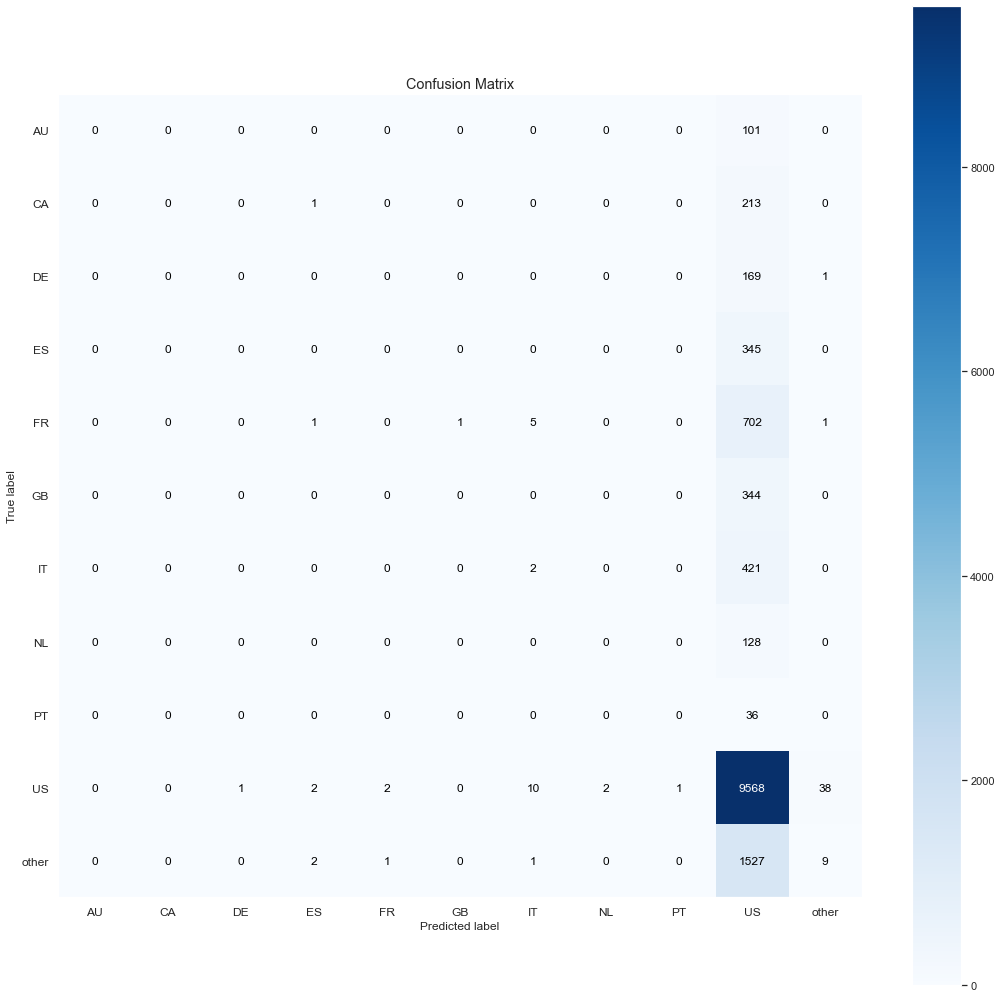

In [64]:
# accuracy: In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

# balanced accuracy: The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class.
balance_acc_nn = m.balanced_accuracy_score(y_test, yhat_nn)
print('Balanced Accuracy: {}'.format(balance_acc_nn))

# kappa metrics: This function computes Cohen’s kappa [1], a score that expresses the level of agreement between two annotators on a classification problem. It is defined as
kappa_nn = m.cohen_kappa_score(y_test, yhat_nn)
print('Kappa Score: {}'.format(kappa_nn))

# classification report: Build a text report showing the main classification metrics.
print(m.classification_report(y_test, yhat_nn))

# confusion matrix: Compute confusion matrix to evaluate the accuracy of a classification.
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(18,18)) 

## NN perfomance - Cross-Validation

In [74]:
x_train = X_train

In [77]:
# generate k-fold for neural network classification:
        # Stratified K-Folds cross-validator, Provides train/test indices to split data in train/test sets. 
        # This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.
num_folds = 5
kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split( x_train, y_train ):
    print( 'Fold Number: {}/{}'.format( i, num_folds ) )
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform( y_train_fold.values.reshape( -1, 1 ) ).toarray()

    # model definition
    model = ml.Sequential()
    model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu' ) )
    model.add( l.Dense( 11, activation='softmax') )

    # compile model
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # training model
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0 )

    # prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = ohe.inverse_transform( pred_nn )
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # metrics
    ## Balanced Accuracy 
    balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn )
    
    ## Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn )
    
    i += 1

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


In [78]:
print( 'Avg Balanced Accuracy: {} +/- {}'.format( np.round( np.mean( balanced_acc_list ), 2 ), 
                                                  np.round( np.std( balanced_acc_list  ), 4 ) ) )
print( 'Avg Kappa: {} +/- {}'.format( np.round( np.mean( kappa_acc_list ), 4 ), 
                                      np.round( np.std( kappa_acc_list ), 4 ) ) )

Avg Balanced Accuracy: 0.09 +/- 0.0008
Avg Kappa: 0.0031 +/- 0.0024
